# Tampa Real-Estate Recommender
## Modeling
TB Real Estate Corporation is a real estate investment firm in the Tampa Bay, Florida area.  The real estate market in the Tampa Bay area is very active.  Single family homes are selling quickly.  TB Real Estate Corporation needs to be able to assess the value of homes coming onto the market quickly and accurately so that they can beat the competition in making a competitive offer.   They need to be able to evaluate the listing price against the predicted sale price in order to identify properties that may be priced below market value and would make good investments.  
<br>
The objective of the Modeling is to evaluate different models and hyperparameters in order to identify a model that will provide the best prediction of sales price.

# 1 Imports and File Locations<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime as dt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree, metrics
from io import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
import warnings;   warnings.filterwarnings("ignore")

In [3]:
ext_data = '../data/external/'
raw_data = '../data/raw/'
interim_data = '../data/interim/'
report_figures = '../reports/figures/'

In [4]:
np.random.seed(42)

# 2 Read Train and Test data into dataframe<a id='2'></a>

The following features (independent variables) will be used to in order to predict the sales amount (S_AMT):
- sales_date_epoch - date of sale as integer (number of days since Jan 1, 1970)
- AGE - age of the home in years at the time of the sale
- tBEDS - number of bedrooms
- tBATHS - number of bathrooms
- JUST - taxable value of home as calculated by the county property appraiser
- HEAT_AR - heated area of home
- ACREAGE - size of property in acres
- LOC_* - location of property in the county

In [5]:
X_train_unscaled = pd.read_csv(interim_data + 'X_train.csv', dtype={'FOLIO': object}, parse_dates=['S_DATE'])
X_test_unscaled = pd.read_csv(interim_data + 'X_test.csv', dtype={'FOLIO': object}, parse_dates=['S_DATE'])
y_train = pd.read_csv(interim_data + 'y_train.csv')
y_test = pd.read_csv(interim_data + 'y_test.csv')
X_train_scaled = pd.read_csv(interim_data + 'X_train_scaled.csv', dtype={'FOLIO': object}, parse_dates=['S_DATE'])
X_test_scaled = pd.read_csv(interim_data + 'X_test_scaled.csv', dtype={'FOLIO': object}, parse_dates=['S_DATE'])

In [6]:
print(f'Train (unscaled): {X_train_unscaled.shape, y_train.shape}')
print(f'Train (scaled): {X_train_scaled.shape, y_train.shape}')
print(f'Test (unscaled): {X_test_unscaled.shape, y_test.shape}')
print(f'Test (scaled): {X_test_scaled.shape, y_test.shape}')

Train (unscaled): ((47883, 10), (47883, 1))
Train (scaled): ((47883, 10), (47883, 1))
Test (unscaled): ((11971, 10), (11971, 1))
Test (scaled): ((11971, 10), (11971, 1))


In [7]:
X_train_unscaled.head()

,FOLIO,S_DATE,sales_date_epoch,AGE,tBEDS,tBATHS,HEAT_AR,ACREAGE,NBHC,SUB_encoded
0,0764231838,2018-04-19,-1.445706,-0.967173,0.536043,0.151300,0.517662,-0.261013,0.908618,-0.377343
1,0554027000,2018-07-27,-1.133147,0.953312,-0.984039,-2.272215,-1.662173,-0.159265,1.030279,-0.948068
2,0774792436,2019-04-09,-0.324916,-0.284334,0.536043,-0.656538,-0.237444,-0.079857,0.908740,-0.746819
3,0723108652,2019-08-01,0.035000,0.270473,-0.984039,-0.656538,-0.795938,-0.146619,0.542415,-0.731716
4,0486800000,2020-02-12,0.650645,1.550797,-0.984039,-2.272215,-1.713464,-0.095344,0.420388,-1.439693


In [8]:
X_test_unscaled.head()

,FOLIO,S_DATE,sales_date_epoch,AGE,tBEDS,tBATHS,HEAT_AR,ACREAGE,NBHC,SUB_encoded
0,0774267814,2020-06-15,1.042132,-0.796463,0.536043,0.151300,0.759866,-0.256323,0.908618,0.123846
1,0779525534,2020-05-13,0.937946,-0.668431,0.536043,-0.656538,-0.919889,-0.275712,0.908252,-0.708528
2,0744056304,2020-07-27,1.174733,-0.668431,-0.984039,0.151300,-0.151961,-0.293039,0.664320,-0.228732
3,0045802994,2019-08-14,0.076043,0.995990,-0.984039,-0.656538,-0.815884,-0.167942,-1.287501,-0.241967
4,1126100000,2020-09-28,1.373633,0.867958,-0.984039,0.151300,1.133145,-0.034114,-2.019540,0.010195


In [9]:
y_train.head()

,S_AMT
0,251200.0
1,155000.0
2,227000.0
3,209000.0
4,119000.0


In [10]:
y_test.head()

,S_AMT
0,298000.0
1,185000.0
2,300000.0
3,232000.0
4,1118000.0


# 3 Evaluate Models<a id='3'></a>

The objective is to predict the sales price which is a continuous variable.  Therefore, the following regression models will be evaluated in order to determine the best model for predicting the sales price.
- K Nearest Neighbors Regressor
- Decision Tree Regressor
- Random Forest Regressor
- Linear Regression
- XGBoost Regressor

In order to optimize the hyper parameters, Randomized Search with 5-fold Cross-Validation will be used.  Randomized Search was chosen over Grid Search in order to reduce processing due to the size of the data.

The R^2 score will be used to determine the best hyper parameters.  This score along with the MSE and RMSE will be used to compare the models.

In [11]:
import math
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [12]:
# Define DataFrame to store results
res_df = pd.DataFrame({'Model': pd.Series(dtype='str'),
                   'Parms': pd.Series(dtype='str'),
                   'R2_Train': pd.Series(dtype='float'),
                   'R2_Test': pd.Series(dtype='float'), 
                   'RMSE': pd.Series(dtype='float')})

In [13]:
X_train = X_train_scaled.drop(['FOLIO', 'S_DATE'], axis=1)
X_test = X_test_scaled.drop(['FOLIO', 'S_DATE'], axis=1)

### Model Tuning and Evaluation

In [14]:
def model_tune(model_id, model, param_dist):
    # Instantiate the RandomizedSearchCV object: model_cv
    model_cv = RandomizedSearchCV(model, param_dist, cv=5)

    # Fit it to the data
    model_cv.fit(X_train, y_train.values.ravel())

    # Print the tuned parameters and score
    print("Model: {}".format(model_id))
    print("Tuned Hyper Parameters: {}".format(model_cv.best_params_))
    print("Best R^2 score is {}".format(model_cv.best_score_))
    
    # Fit model with optimal hyper parameters
    model.set_params(**model_cv.best_params_)
    model.fit(X_train, y_train.values.ravel())
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    print(f"R^2 Train Score: {r2_train}")
    print(f"R^2 Test Score: {r2_test}")
    
    # Calculate Root Mean Squared Error
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    print("Mean Squared Error:",mse)
    print("Root Mean Squared Error:", rmse)
    
    # Plot Results
    fig, ax = plt.subplots(figsize=(20, 10))    
    x_ax=range(y_test.shape[0])
    plt.scatter(x_ax, y_test, s=5, color="blue", label="actual")
    plt.scatter(x_ax, y_pred, s=5, color="red", label="predicted")
#    plt.plot(x_ax, y_test, lw=1.5, color="blue", label="actual")
#    plt.plot(x_ax, y_pred, lw=1.5, color="red", label="predicted")
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.xlabel('Property Sale')
    plt.ylabel('Sales Price')
    plt.legend()
    plt.show()
    
    # Append results to DataFrame
    res = pd.DataFrame([[model_id, model_cv.best_params_, r2_train, r2_test, rmse]], 
                      columns=['Model', 'Parms', 'R2_Train', 'R2_Test', 'RMSE'])
    return res, y_pred

### K Nearest Neighbor Regressor

Model: KNN
Tuned Hyper Parameters: {'weights': 'uniform', 'n_neighbors': 10}
Best R^2 score is 0.8520959306987523
R^2 Train Score: 0.8847468488796049
R^2 Test Score: 0.8389201540652348
Mean Squared Error: 3546310138.105348
Root Mean Squared Error: 59550.90375557157


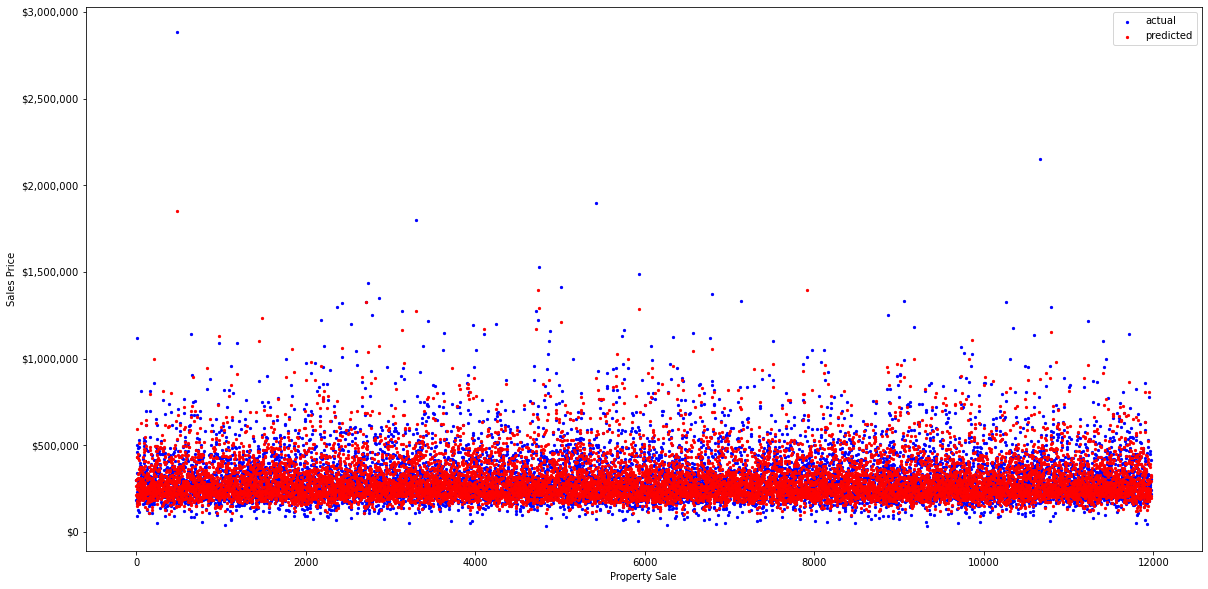

,Model,Parms,R2_Train,R2_Test,RMSE
0,KNN,"{'weights': 'uniform', 'n_neighbors': 10}",0.884747,0.83892,59550.903756


In [15]:
knr = KNeighborsRegressor()
param_dist = {'n_neighbors':np.arange(1,50),
              "weights": ["uniform", "distance"]}
res, y_pred_knr = model_tune('KNN', knr, param_dist)
res_df = pd.concat([res_df, res])
res_df.head()

In [16]:
df_results =  pd.concat([X_test_unscaled, y_test], axis=1)
df_results['predicted_price'] = y_pred_knr
df_results['abs_error'] = (df_results['S_AMT'] - df_results['predicted_price']).abs()
df_results['pct_error'] = df_results.abs_error / df_results.S_AMT

In [17]:
df_orig = pd.read_csv(interim_data + 'sales_df.csv', dtype={'FOLIO': object, 'DOR_CODE': object, 'NBHC': object, 'SECTION_CD': object, 'TOWNSHIP_CD': object, 'RANGE_CD': object}, parse_dates=['S_DATE'])

In [18]:
df_results = pd.merge(df_results, df_orig[[i for i in df_orig.columns if i not in df_results.columns] + ['FOLIO','S_DATE']],  how='inner', on=['FOLIO','S_DATE'])

In [19]:
df_results.to_csv(interim_data + 'knn_results.csv', index=False)

In [20]:
df_results.sort_values(by='pct_error',ascending=False).head(10)

,FOLIO,S_DATE,sales_date_epoch,AGE,tBEDS,tBATHS,HEAT_AR,ACREAGE,NBHC,SUB_encoded,...,TIF,BASE,MUNICIPALITY_CD,SECTION_CD,TOWNSHIP_CD,RANGE_CD,BLOCK_NUM,LOT_NUM,MARKET_AREA_CD,REGION
3718,0473080000,2018-03-07,-1.581463,-1.095205,-0.984039,1.766976,0.201372,0.442801,0.420510,-0.767892,...,0,2019,U,35,29,19,000001,63990.0,22,East_Bay
6968,1561440000,2018-09-06,-1.003704,2.148281,0.536043,-0.656538,-0.322928,-0.282372,-1.653704,-0.877414,...,9,1995,A,05,29,19,000008,00002.0,5,Tampa
6278,1744250000,2020-10-30,1.474662,2.959153,-0.984039,-2.272215,-1.878732,-0.311935,-1.654070,-0.817547,...,9,2020,A,08,29,19,000000,00038.0,5,Tampa
6646,0862010300,2019-07-18,-0.009200,-1.009850,0.536043,0.959138,0.662984,1.919738,0.543513,-0.092584,...,0,2021,U,29,29,21,000004,14610.0,23,Eastern
9345,0956810000,2019-10-31,0.322301,1.294732,-0.984039,-2.272215,-1.749082,-0.222779,-0.555461,-0.958833,...,E,1992,A,13,28,18,D00000,00009.0,14,Northern
7406,0339604214,2018-12-28,-0.646946,-1.009850,-0.984039,-0.656538,0.576076,1.684953,-0.433312,2.628890,...,0,2020,U,20,27,19,000000,00002.0,15,Northern
8167,0498130000,2019-11-08,0.347558,1.849539,-0.984039,-0.656538,-1.348733,-0.188095,0.420144,0.010195,...,0,1972,U,23,30,19,000000,00041.0,22,East_Bay
4852,1887190000,2018-08-10,-1.088947,3.215217,-0.984039,-2.272215,-1.901528,-0.335815,-1.654070,-1.047410,...,9,1996,A,17,29,19,000002,00004.0,5,Tampa
244,1001100100,2018-06-06,-1.294162,2.105604,-0.984039,0.151300,-1.512577,-0.358042,-1.530090,-1.054116,...,0,1989,A,24,28,18,000013,00008.0,6,Tampa
10801,2067470000,2020-05-28,0.985303,1.380087,-0.984039,-0.656538,-0.191853,-0.274425,0.298727,-1.203060,...,3,2005,P,28,28,22,000019,00005.1,21,Northeast


Error Analysis - Review Nearest Neighbors

In [21]:
X_test_unscaled[X_test_unscaled.FOLIO == '0542430862']

,FOLIO,S_DATE,sales_date_epoch,AGE,tBEDS,tBATHS,HEAT_AR,ACREAGE,NBHC,SUB_encoded


In [22]:
X_neighbors = knr.kneighbors(X_test.iloc[[1229]].values.reshape(1, -1), n_neighbors=17)
X_neighbors

(array([[1.09536537, 1.11835431, 1.15004328, 1.15532933, 1.17471199,
         1.17589401, 1.20965196, 1.24886457, 1.27858572, 1.2859371 ,
         1.29660621, 1.30869553, 1.31245419, 1.32904378, 1.33994786,
         1.34879858, 1.35140441]]),
 array([[12644, 34759, 16446,  8821, 47097, 10954, 28858, 32694, 46335,
         43161, 39800, 18430, 19763, 40093, 44189, 23657, 30029]],
       dtype=int64))

In [23]:
X_train_unscaled[X_train_unscaled.index.isin(X_neighbors[1].tolist()[0])]

,FOLIO,S_DATE,sales_date_epoch,AGE,tBEDS,tBATHS,HEAT_AR,ACREAGE,NBHC,SUB_encoded
8821,0777141972,2019-06-17,-0.107072,-0.967173,2.056126,1.766976,3.311556,-0.137977,0.909960,0.382206
10954,0771926588,2019-10-31,0.322301,-0.967173,2.056126,1.766976,2.993841,-0.082576,0.908496,0.022231
12644,0774362788,2019-06-21,-0.094444,-0.967173,2.056126,1.766976,3.372819,-0.059149,0.908618,0.358857
16446,0777140604,2019-04-30,-0.258616,-0.924495,2.056126,1.766976,2.926879,-0.180131,0.909960,-0.083481
18430,0776940410,2019-09-27,0.214958,-0.967173,2.056126,1.766976,2.911207,-0.157921,0.909838,0.508004
19763,0592270776,2019-01-25,-0.558545,-0.497721,2.056126,1.766976,2.971045,-0.128715,-0.311041,-0.077636
23657,0777140838,2019-02-08,-0.514345,-0.924495,2.056126,2.574814,3.412711,0.036326,0.909960,0.395181
28858,0542430950,2019-06-28,-0.072344,-0.455043,2.056126,2.574814,2.602041,0.382130,1.031499,-0.197547
30029,0777140462,2019-02-20,-0.476459,-0.881818,2.056126,0.959138,2.422525,0.415674,0.909960,0.122874
32694,0777141338,2019-05-09,-0.230201,-0.967173,2.056126,1.766976,2.441046,0.037933,0.909960,-0.197942


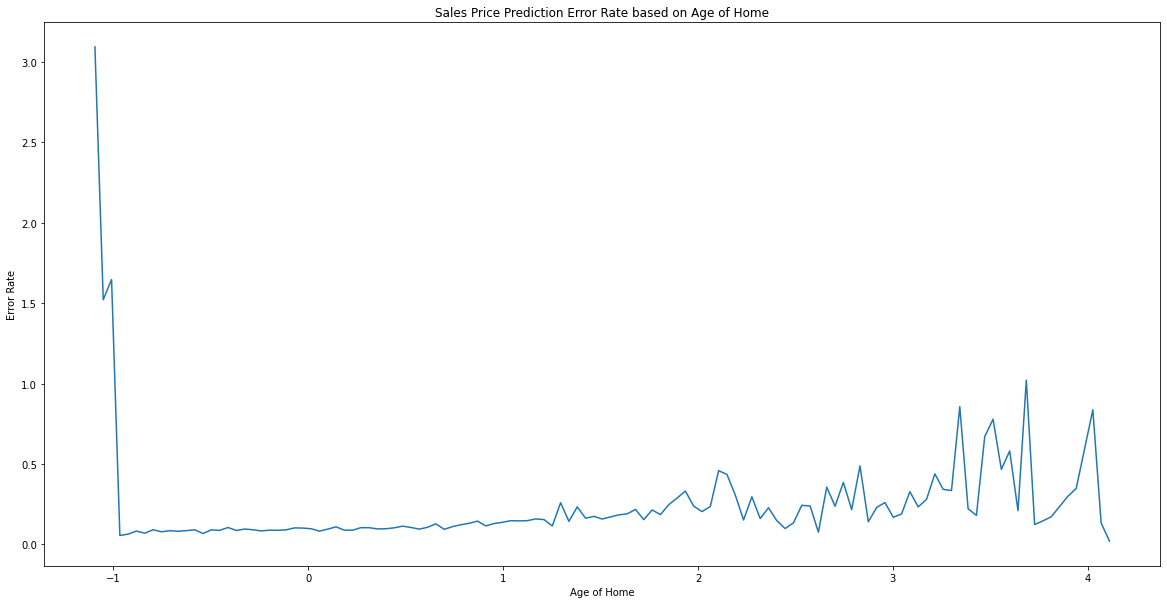

In [24]:
df_error = df_results.groupby('AGE').mean('pct_error').reset_index()
fig, ax = plt.subplots(figsize=(20, 10))   
plt.plot('AGE', 'pct_error', data=df_error)
plt.xlabel('Age of Home')
plt.ylabel('Error Rate')
plt.title('Sales Price Prediction Error Rate based on Age of Home')
plt.show()

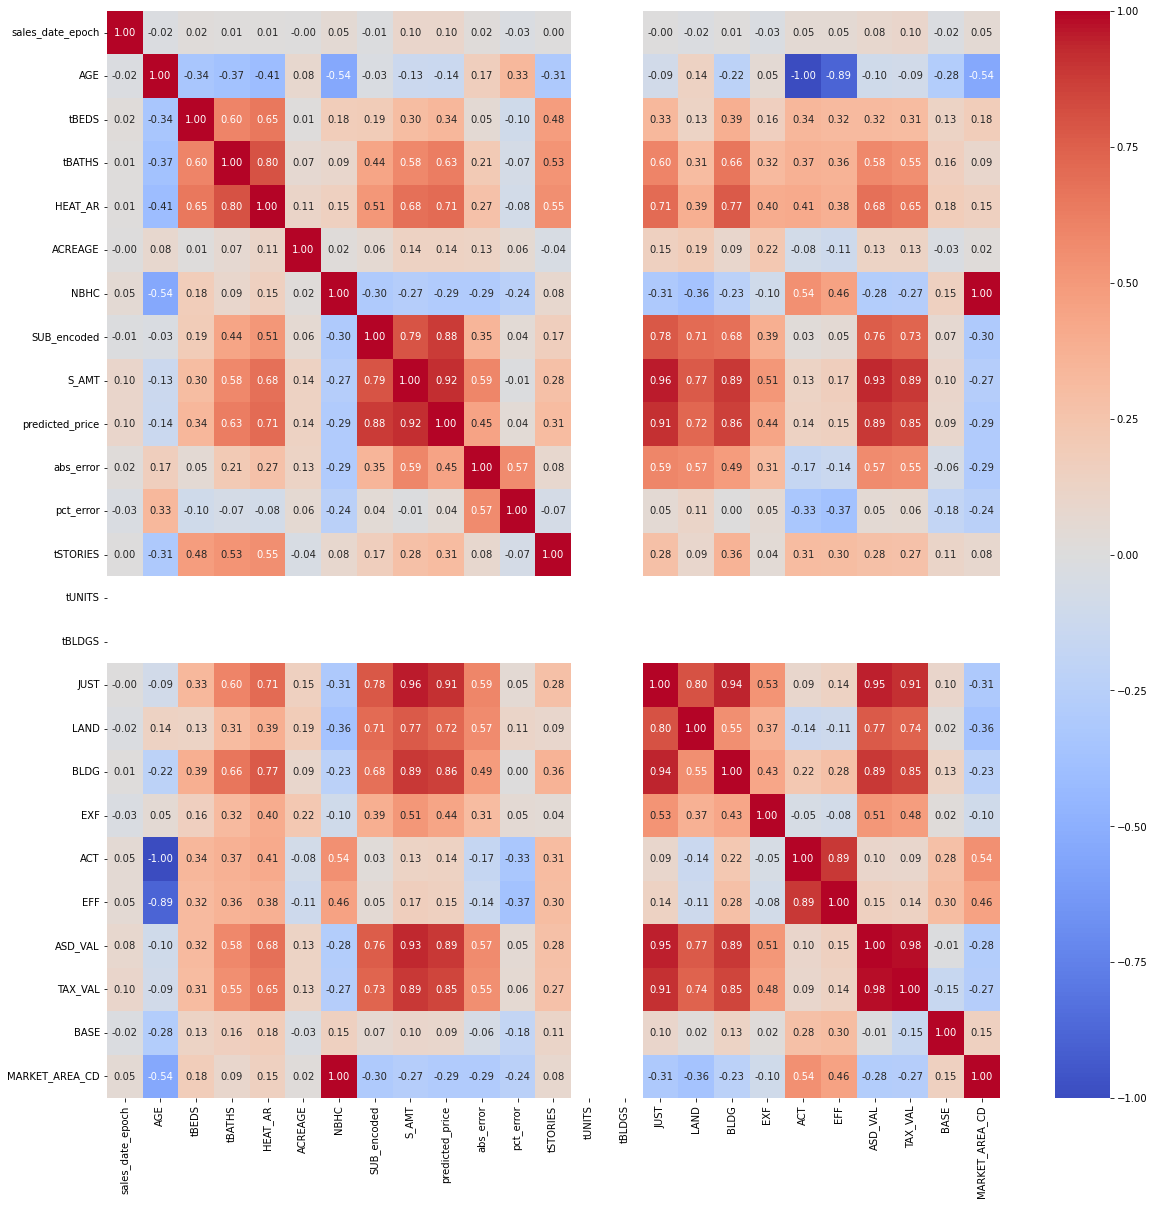

In [25]:
corr = df_results.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(round(corr, 2), annot=True, fmt='.2f', cmap="coolwarm");

### Decision Tree Regressor

Model: DTR
Tuned Hyper Parameters: {'splitter': 'best', 'min_weight_fraction_leaf': 0.1, 'min_samples_leaf': 10, 'max_leaf_nodes': 50, 'max_features': 'auto', 'max_depth': 7}
Best R^2 score is 0.5753260588509954
R^2 Train Score: 0.5756317869162799
R^2 Test Score: 0.5359765563834201
Mean Squared Error: 10215871717.945787
Root Mean Squared Error: 101073.59555267531


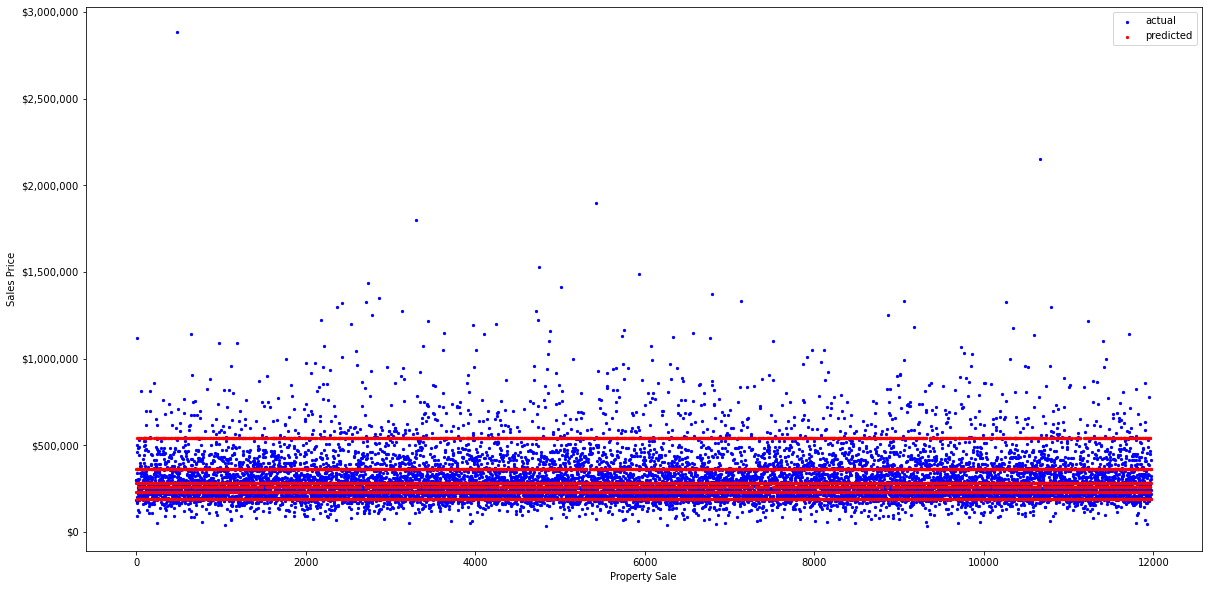

,Model,Parms,R2_Train,R2_Test,RMSE
0,KNN,"{'weights': 'uniform', 'n_neighbors': 10}",0.884747,0.838920,59550.903756
0,DTR,"{'splitter': 'best', 'min_weight_fraction_leaf...",0.575632,0.535977,101073.595553


In [26]:
dtr = DecisionTreeRegressor()
param_dist = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}
res, y_pred_dtr = model_tune('DTR', dtr, param_dist)
res_df = pd.concat([res_df, res])
res_df.head()

### Random Forest Regressor

Model: RFR
Tuned Hyper Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}
Best R^2 score is 0.8851831484622629
R^2 Train Score: 0.9523203946586861
R^2 Test Score: 0.8867416548284346
Mean Squared Error: 2493479028.218209
Root Mean Squared Error: 49934.747703560184


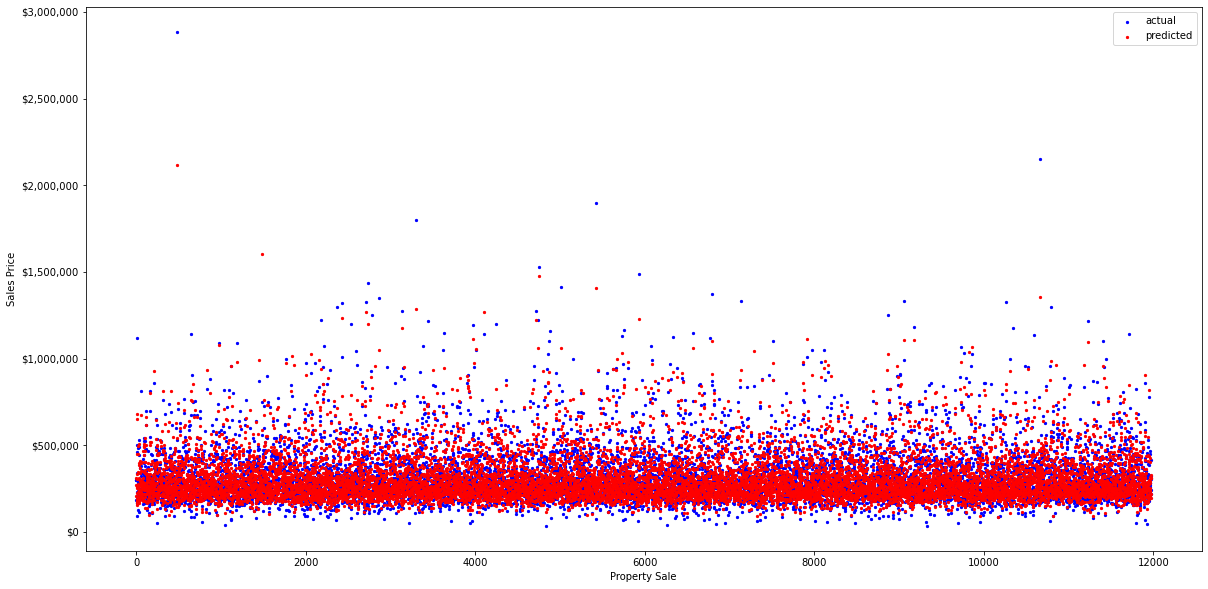

,Model,Parms,R2_Train,R2_Test,RMSE
0,KNN,"{'weights': 'uniform', 'n_neighbors': 10}",0.884747,0.838920,59550.903756
0,DTR,"{'splitter': 'best', 'min_weight_fraction_leaf...",0.575632,0.535977,101073.595553
0,RFR,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.952320,0.886742,49934.747704


In [27]:
rfr = RandomForestRegressor()
param_dist = {'bootstrap': [True, False],
             'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 3, 4],
             'min_samples_split': [2, 6, 10],
             'n_estimators': [5,20,50,100]}
res, y_pred = model_tune('RFR', rfr, param_dist)
res_df = pd.concat([res_df, res])
res_df.head()

### Linear Regression

Model: LNR
Tuned Hyper Parameters: {'fit_intercept': True}
Best R^2 score is 0.811260833362985
R^2 Train Score: 0.8113180127252092
R^2 Test Score: 0.7688864386526354
Mean Squared Error: 5088162090.69207
Root Mean Squared Error: 71331.35419079095


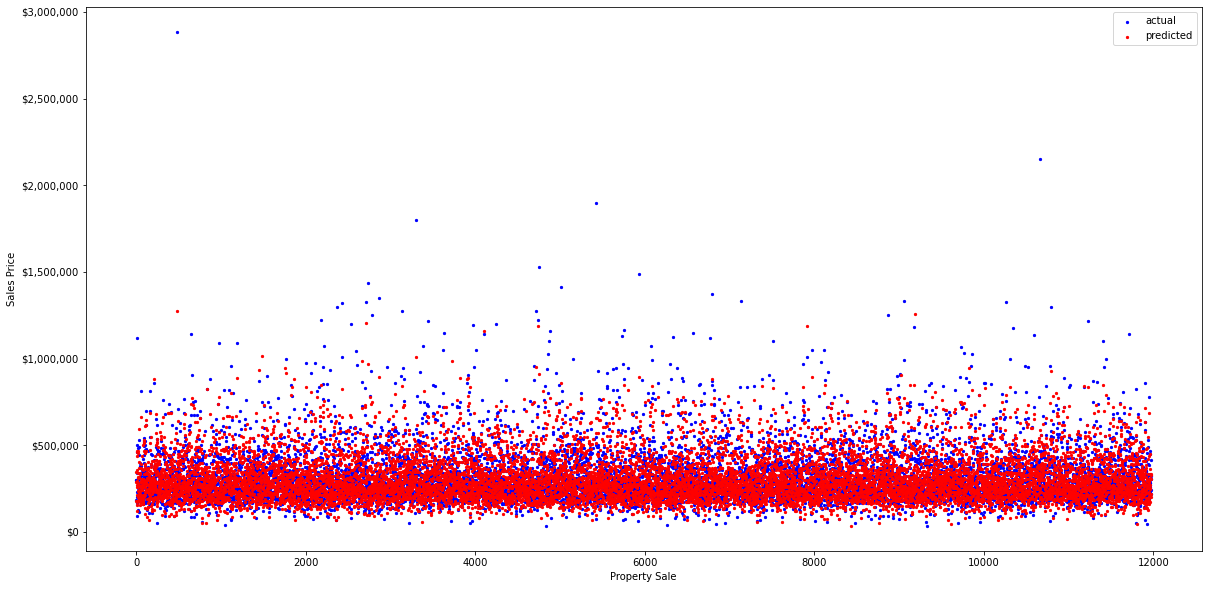

,Model,Parms,R2_Train,R2_Test,RMSE
0,KNN,"{'weights': 'uniform', 'n_neighbors': 10}",0.884747,0.838920,59550.903756
0,DTR,"{'splitter': 'best', 'min_weight_fraction_leaf...",0.575632,0.535977,101073.595553
0,RFR,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.952320,0.886742,49934.747704
0,LNR,{'fit_intercept': True},0.811318,0.768886,71331.354191


In [28]:
lnr = LinearRegression()
param_dist = {'fit_intercept': [True, False]}
res, y_pred_lnr = model_tune('LNR', lnr, param_dist)
res_df = pd.concat([res_df, res])
res_df.head()

In [29]:
# TODO: Coefficients and Features
lnr.coef_

array([ 13789.23792685,  -5417.76674345,  -9310.64762058,  10057.8061975 ,
        50911.10580955,   9836.14366478, -23385.51284409,  87100.9304448 ])

### Extreme Gradient Boost Regressor

Model: XGB
Tuned Hyper Parameters: {'n_estimators': 900, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2}
Best R^2 score is 0.8915302071935104
R^2 Train Score: 0.975413783034017
R^2 Test Score: 0.9016747040808422
Mean Squared Error: 2164715217.6413956
Root Mean Squared Error: 46526.500165404614


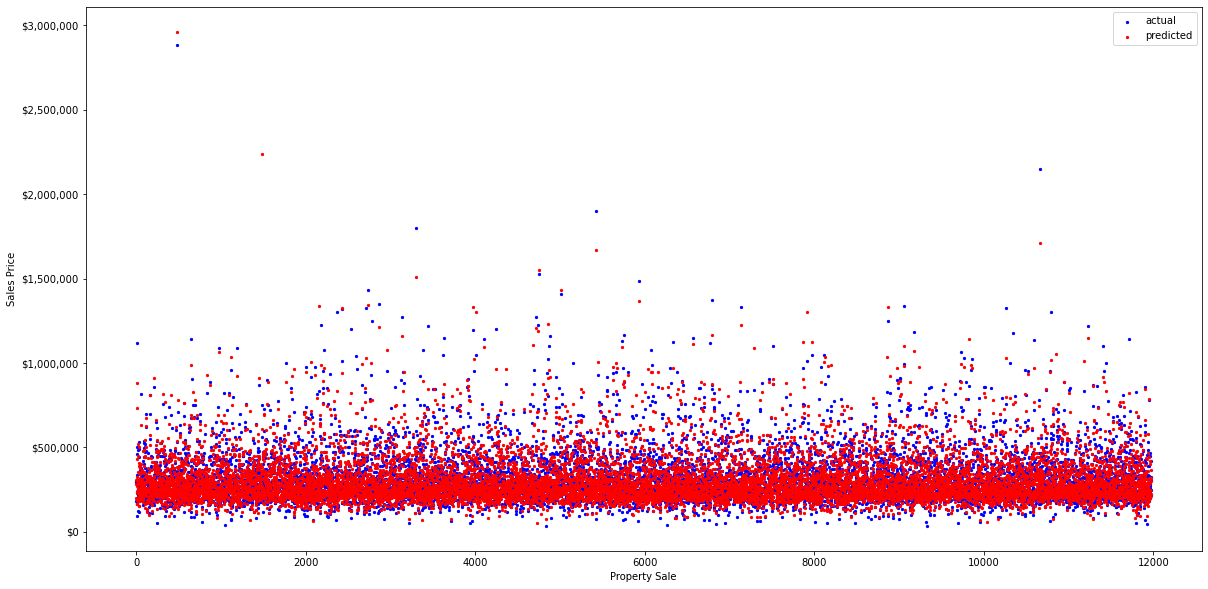

,Model,Parms,R2_Train,R2_Test,RMSE
0,KNN,"{'weights': 'uniform', 'n_neighbors': 10}",0.884747,0.838920,59550.903756
0,DTR,"{'splitter': 'best', 'min_weight_fraction_leaf...",0.575632,0.535977,101073.595553
0,RFR,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.952320,0.886742,49934.747704
0,LNR,{'fit_intercept': True},0.811318,0.768886,71331.354191
0,XGB,"{'n_estimators': 900, 'min_child_weight': 3, '...",0.975414,0.901675,46526.500165


In [30]:
xgb = XGBRegressor()
param_dist = {
            'n_estimators': [100, 500, 900, 1100, 1500],
            'max_depth': [2, 3, 5, 10, 15],
            'learning_rate': [0.05, 0.1, 0.15, 0.20],
            'min_child_weight': [1, 2, 3, 4]
            }
res, y_pred_xgb = model_tune('XGB', xgb, param_dist)
res_df = pd.concat([res_df, res])
res_df.head()

In [31]:
xgb.feature_importances_

array([0.02187709, 0.01806453, 0.01273163, 0.04610461, 0.1136393 ,
       0.01991224, 0.06961891, 0.6980517 ], dtype=float32)

In [32]:
sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: -x[1])

[('SUB_encoded', 0.6980517),
 ('HEAT_AR', 0.1136393),
 ('NBHC', 0.06961891),
 ('tBATHS', 0.046104614),
 ('sales_date_epoch', 0.021877086),
 ('ACREAGE', 0.019912235),
 ('AGE', 0.018064529),
 ('tBEDS', 0.012731634)]

In [33]:
df_results =  pd.concat([X_test_unscaled, y_test], axis=1)
df_results['predicted_price'] = y_pred_xgb
df_results['abs_error'] = (df_results['S_AMT'] - df_results['predicted_price']).abs()
df_results['pct_error'] = df_results.abs_error / df_results.S_AMT

In [34]:
df_orig = pd.read_csv(interim_data + 'sales_df.csv', dtype={'FOLIO': object, 'DOR_CODE': object, 'NBHC': object, 'SECTION_CD': object, 'TOWNSHIP_CD': object, 'RANGE_CD': object}, parse_dates=['S_DATE'])

In [35]:
df_results = pd.merge(df_results, df_orig[[i for i in df_orig.columns if i not in df_results.columns] + ['FOLIO','S_DATE']],  how='inner', on=['FOLIO','S_DATE'])

In [36]:
df_results.to_csv(interim_data + 'xgb_results.csv', index=False)

In [37]:
df_results.sort_values(by='pct_error',ascending=False).head(10)

,FOLIO,S_DATE,sales_date_epoch,AGE,tBEDS,tBATHS,HEAT_AR,ACREAGE,NBHC,SUB_encoded,...,TIF,BASE,MUNICIPALITY_CD,SECTION_CD,TOWNSHIP_CD,RANGE_CD,BLOCK_NUM,LOT_NUM,MARKET_AREA_CD,REGION
9345,0956810000,2019-10-31,0.322301,1.294732,-0.984039,-2.272215,-1.749082,-0.222779,-0.555461,-0.958833,...,E,1992,A,13,28,18,D00000,00009.0,14,Northern
6968,1561440000,2018-09-06,-1.003704,2.148281,0.536043,-0.656538,-0.322928,-0.282372,-1.653704,-0.877414,...,9,1995,A,05,29,19,000008,00002.0,5,Tampa
1048,1741550000,2018-08-06,-1.101576,3.513959,-0.984039,-2.272215,-1.525399,-0.313461,-1.654070,-1.134231,...,9,1995,A,08,29,19,000013,00014.0,5,Tampa
9713,1873880000,2018-07-31,-1.120519,3.471282,-0.984039,-0.656538,-1.182040,-0.382770,-1.654070,-1.048294,...,9,1979,A,07,29,19,000005,00008.0,5,Tampa
1484,1856130000,2018-09-25,-0.943718,3.343250,2.056126,1.766976,3.303007,-0.172970,-1.897758,6.113013,...,0,2019,A,26,29,18,000010,00004.0,3,South_Tampa
6278,1744250000,2020-10-30,1.474662,2.959153,-0.984039,-2.272215,-1.878732,-0.311935,-1.654070,-0.817547,...,9,2020,A,08,29,19,000000,00038.0,5,Tampa
5091,1870080000,2019-05-30,-0.163901,3.343250,-0.984039,-0.656538,-0.567981,-0.279738,-1.654070,-0.308930,...,9,2022,A,07,29,19,000001,00014.0,5,Tampa
7406,0339604214,2018-12-28,-0.646946,-1.009850,-0.984039,-0.656538,0.576076,1.684953,-0.433312,2.628890,...,0,2020,U,20,27,19,000000,00002.0,15,Northern
6263,0811143206,2018-07-16,-1.167876,2.916475,0.536043,0.959138,0.754167,2.302822,0.786347,0.010195,...,0,2021,U,23,30,21,000000,00003.0,25,Eastern
10801,2067470000,2020-05-28,0.985303,1.380087,-0.984039,-0.656538,-0.191853,-0.274425,0.298727,-1.203060,...,3,2005,P,28,28,22,000019,00005.1,21,Northeast


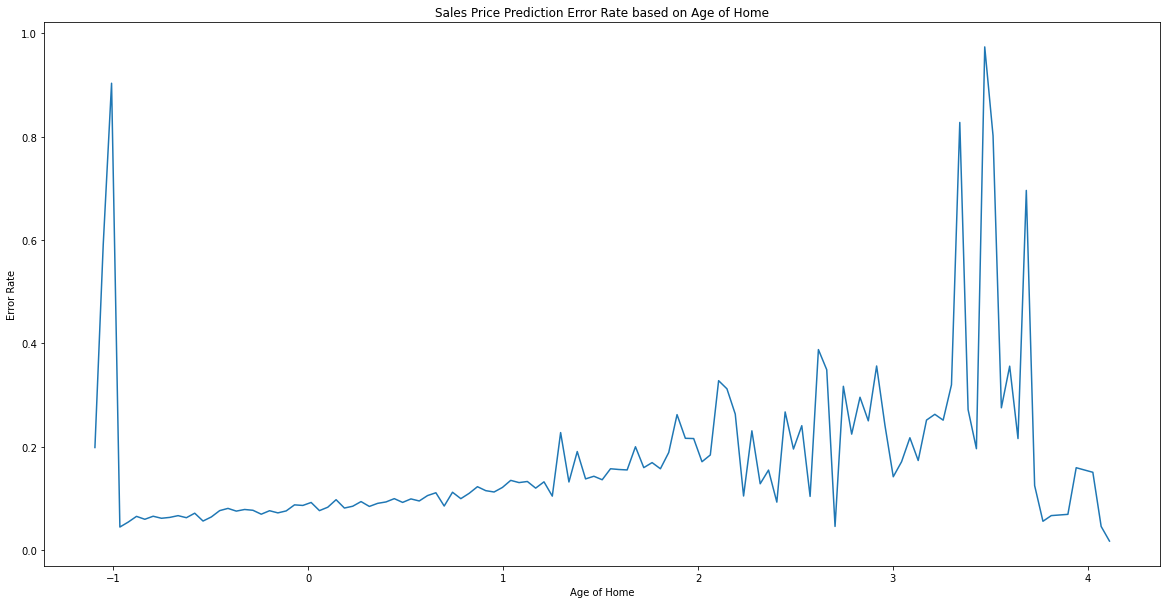

In [38]:
df_error = df_results.groupby('AGE').mean('pct_error').reset_index()
fig, ax = plt.subplots(figsize=(20, 10))   
plt.plot('AGE', 'pct_error', data=df_error)
plt.xlabel('Age of Home')
plt.ylabel('Error Rate')
plt.title('Sales Price Prediction Error Rate based on Age of Home')
plt.show()

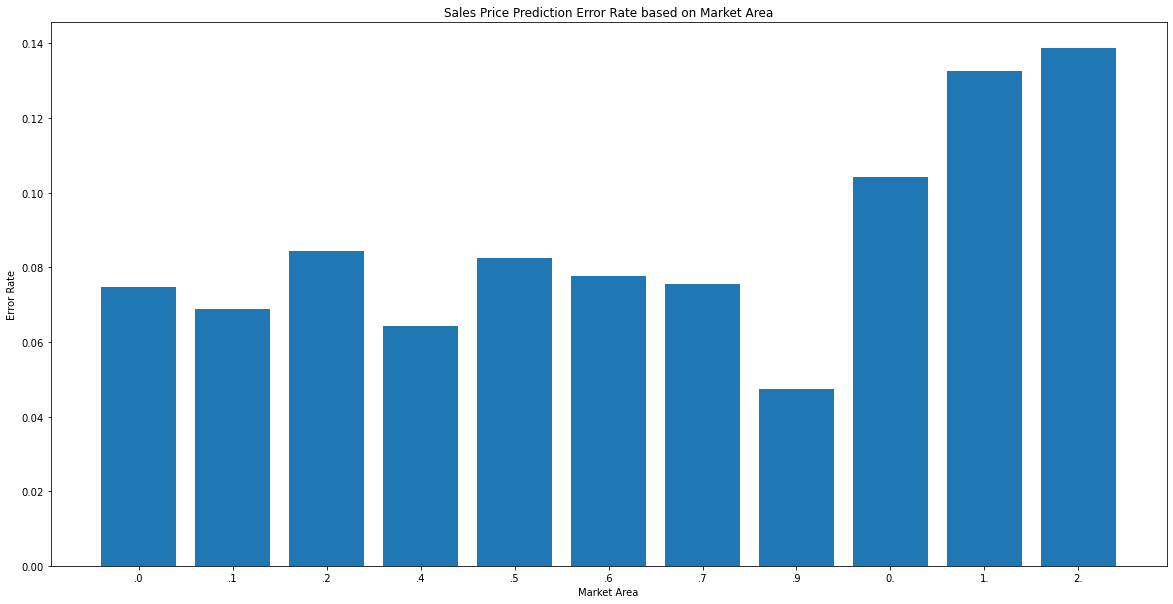

In [39]:
df_results['MARKET_AREA_CD'] = df_results['NBHC'].astype(str).str[1:3]
df_error_mkt = df_results.groupby('MARKET_AREA_CD').mean('pct_error').reset_index()
fig, ax = plt.subplots(figsize=(20, 10))   
plt.bar('MARKET_AREA_CD', 'pct_error', data=df_error_mkt)
plt.xlabel('Market Area')
plt.ylabel('Error Rate')
plt.title('Sales Price Prediction Error Rate based on Market Area')
plt.show()

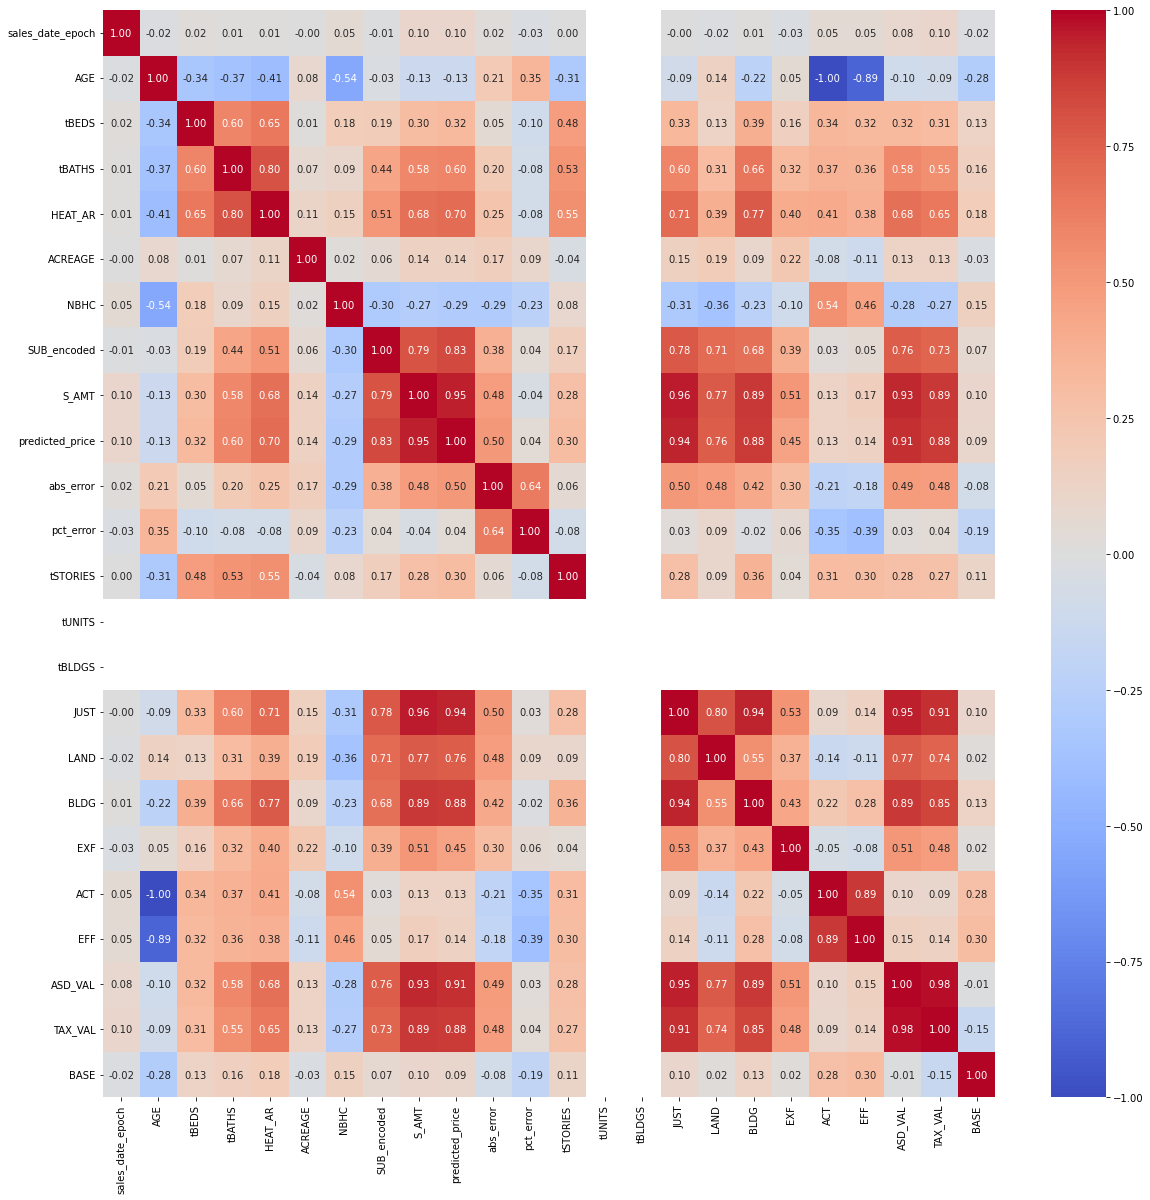

In [40]:
corr = df_results.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(round(corr, 2), annot=True, fmt='.2f', cmap="coolwarm");

<AxesSubplot:>

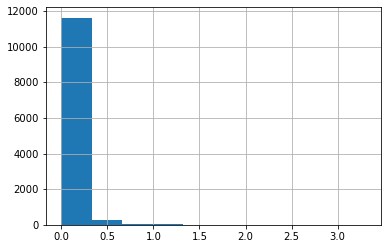

In [41]:
df_results.pct_error.hist()

# 4 Results<a id='4'></a>

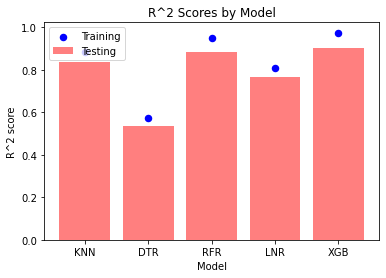

In [42]:
# Plot Results
plt.scatter(res_df.Model, res_df.R2_Train, lw=1.5, color="blue", label="Training")
plt.bar(res_df.Model, res_df.R2_Test, lw=1.5, color="red", label="Testing", alpha=0.5)
plt.title('R^2 Scores by Model')
plt.xlabel('Model')
plt.ylabel('R^2 score')
plt.legend()
plt.show()

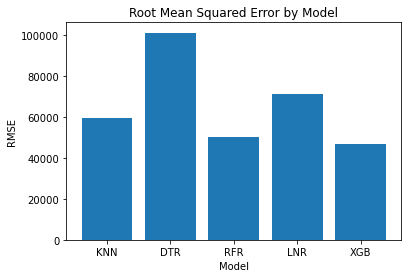

In [43]:
plt.bar(res_df.Model, res_df.RMSE)
plt.title('Root Mean Squared Error by Model')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

# 5 Conclusion<a id='5'></a>

The following conclusions were made based on the models:
- All of the models had similar scores except for the Decision Tree Regressor which performed poorly.
- The Extreme Gradient Boosting Regressor (XGBoost) model slightly outperformed the K Nearest Neighbor, Random Forest, and Linear Regression models.
- The Linear Regression model is simpler and less expensive computationally than the competition.  Based on the current data, this would be the best model

The Root Mean Squared Error (RMSE) of approximately \\$60K is fairly large when considering the average sales price is approximately $390K.  In order to improve the model, more independent features may be helpful. Some helpful features may include the condition of the property and structure, whether it is in a planned community, waterfront property, crime rate of the neighborhood, ratings of the schools, etc. 